In [2]:
!pip install transformers sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [3]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.9 MB/s eta 0:00:00


In [4]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
model_name = "bigscience/bloom-1b7"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Use float16 + device_map to manage memory
model = AutoModel.from_pretrained(
    model_name,
    device_map="auto",        # Automatically splits across CPU/GPU
    torch_dtype=torch.float16 # Use half precision (requires GPU with float16 support, like A100)
)

model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

BloomModel(
  (word_embeddings): Embedding(250880, 2048)
  (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (h): ModuleList(
    (0-23): 24 x BloomBlock(
      (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (self_attention): BloomAttention(
        (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
        (dense): Linear(in_features=2048, out_features=2048, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
      )
      (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (mlp): BloomMLP(
        (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
        (gelu_impl): BloomGelu()
        (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
)

In [6]:
df = pd.read_csv("/content/oxford3000_translated.csv", encoding='utf-8')
words = {}
for index, row in df.iterrows():
  en_word = row['en']
  words[en_word] = {"hi": row['hi'], "kn":row['kn'], "fr":row['fr']}
words

{'a': {'hi': 'ए', 'kn': 'ಒಂದು', 'fr': 'un'},
 'abandon': {'hi': 'छोड़ देना', 'kn': 'ಕೈಬಿಡು', 'fr': 'abandonner'},
 'ability': {'hi': 'क्षमता', 'kn': 'ಸಾಮರ್ಥ್ಯ', 'fr': 'capacité'},
 'able': {'hi': 'योग्य', 'kn': 'ಸಮರ್ಥ', 'fr': 'capable'},
 'about': {'hi': 'के बारे में', 'kn': 'ಬಗ್ಗೆ', 'fr': 'à propos'},
 'above': {'hi': 'ऊपर', 'kn': 'ಮೇಲೆ', 'fr': 'au-dessus de'},
 'abroad': {'hi': 'विदेश', 'kn': 'ವಿದೇಶ', 'fr': "à l'étranger"},
 'absolute': {'hi': 'निरपेक्ष', 'kn': 'ಅತ್ಯುತ್ಸಾಹದ', 'fr': 'absolu'},
 'absolutely': {'hi': 'बिल्कुल', 'kn': 'ಸಂಪೂರ್ಣವಾಗಿ', 'fr': 'absolument'},
 'academic': {'hi': 'अकादमिक', 'kn': 'ಶೈಕ್ಷಣಿಕ', 'fr': 'académique'},
 'accept': {'hi': 'स्वीकार करना', 'kn': 'ಒಪ್ಪಿಸು', 'fr': 'accepter'},
 'acceptable': {'hi': 'स्वीकार्य', 'kn': 'ಸ್ವೀಕಾರಾರ್ಹ', 'fr': 'acceptable'},
 'access': {'hi': 'पहुँच', 'kn': 'ಪ್ರವೇಶ', 'fr': 'accéder'},
 'accident': {'hi': 'दुर्घटना', 'kn': 'ಅಪಘಾತ', 'fr': 'accident'},
 'accommodation': {'hi': 'आवास', 'kn': 'ಸೌಕರ್ಯ', 'fr': 'hébergement'},
 'accompan

In [9]:
def get_word_embedding(word, tokenizer, model):
    with torch.no_grad():
        tokens = tokenizer(word, return_tensors="pt").to(model.device)  # Move inputs to model’s device
        output = model(**tokens)
        last_hidden_state = output.last_hidden_state.squeeze(0)  # (seq_len, hidden_size)

        # Take mean of token embeddings
        word_embedding = last_hidden_state.mean(dim=0).cpu().numpy()  # Move result back to CPU
        return word_embedding

In [10]:
from tqdm import tqdm

embedding_dict = {
    "en": [],
    "fr": [],
    "hi": [],
    "kn": [],
    "labels": []
}

for en_word, translations in tqdm(words.items(), desc="Generating embeddings"):
    embedding_dict["labels"].append(en_word)
    embedding_dict["en"].append(get_word_embedding(en_word, tokenizer, model))
    embedding_dict["fr"].append(get_word_embedding(translations["fr"], tokenizer, model))
    embedding_dict["hi"].append(get_word_embedding(translations["hi"], tokenizer, model))
    embedding_dict["kn"].append(get_word_embedding(translations["kn"], tokenizer, model))

Generating embeddings: 100%|██████████| 2830/2830 [04:10<00:00, 11.30it/s]


In [11]:
records = []

for i in range(len(embedding_dict["labels"])):
    word = embedding_dict["labels"][i]
    for lang in ["en", "fr", "hi", "kn"]:
        embedding = embedding_dict[lang][i]

        # Get the word in that language
        if lang == "en":
            translated_word = word
        else:
            translated_word = words[word][lang]

        # Create a record
        record = {
            "word": translated_word,
            "lang": lang
        }
        for j, val in enumerate(embedding):
            record[f"dim_{j}"] = val

        records.append(record)

# Save as DataFrame
df_embed = pd.DataFrame(records)
df_embed.to_csv("word_embeddings_bloom1_7B.csv", index=False)
print("✅ Embeddings saved to word_embeddings.csv")
df_embed.head()

✅ Embeddings saved to word_embeddings.csv


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,word,lang,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_2038,dim_2039,dim_2040,dim_2041,dim_2042,dim_2043,dim_2044,dim_2045,dim_2046,dim_2047
0,a,en,-1.089844,-1.005859,-7.289062,-0.012352,-2.718750,-0.411621,0.126221,-0.536133,...,-1.310547,0.285156,3.451172,-4.480469,0.301025,-0.149536,2.285156,-5.574219,1.626953,-0.480713
1,un,fr,-1.087891,2.228516,-5.636719,-1.043945,-0.808594,0.162231,-0.139282,-0.788086,...,-0.152466,-3.269531,2.574219,-4.175781,0.653809,1.353516,-1.629883,-2.750000,-0.868164,-0.001356
2,ए,hi,-2.708984,3.751953,-5.980469,-1.431641,-3.818359,-5.222656,3.710938,2.583984,...,-3.019531,0.031830,-1.046875,-3.906250,3.119141,0.214478,5.195312,2.121094,1.846680,3.511719
3,ಒಂದು,kn,-0.438965,2.005859,-4.320312,0.915527,-2.529297,-4.140625,1.833008,-0.616211,...,2.048828,-2.796875,-0.420654,-3.736328,3.490234,2.546875,4.503906,1.537109,1.080078,0.848145
4,abandon,en,-2.412109,-0.128662,-6.734375,-1.667969,-2.283203,1.326172,-0.480957,-0.994141,...,-1.263672,4.785156,0.047363,-5.289062,-0.871094,-0.062500,2.582031,-3.406250,0.250977,-0.648926


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_pairwise_similarities(embedding_dict, pairs=[("en", "fr"), ("en", "hi"), ("en", "kn"), ("hi", "kn")]):
    pairwise_data = []

    for i, word in enumerate(embedding_dict["labels"]):
        for lang1, lang2 in pairs:
            vec1 = embedding_dict[lang1][i]
            vec2 = embedding_dict[lang2][i]
            sim = cosine_similarity([vec1], [vec2])[0][0]
            pairwise_data.append({
                "Word": word,
                "Language Pair": f"{lang1.upper()}–{lang2.upper()}",
                "Cosine Similarity": sim
            })

    return pairwise_data

In [13]:
similarity_data = compute_pairwise_similarities(embedding_dict)

df_sim = pd.DataFrame(similarity_data)

In [14]:
df_sim

,Word,Language Pair,Cosine Similarity
0,a,EN–FR,0.956479
1,a,EN–HI,-0.207750
2,a,EN–KN,-0.604387
3,a,HI–KN,0.258865
4,abandon,EN–FR,0.972681
...,...,...,...
11315,zero,HI–KN,-0.011149
11316,zone,EN–FR,1.000000
11317,zone,EN–HI,-0.219762
11318,zone,EN–KN,-0.020873


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


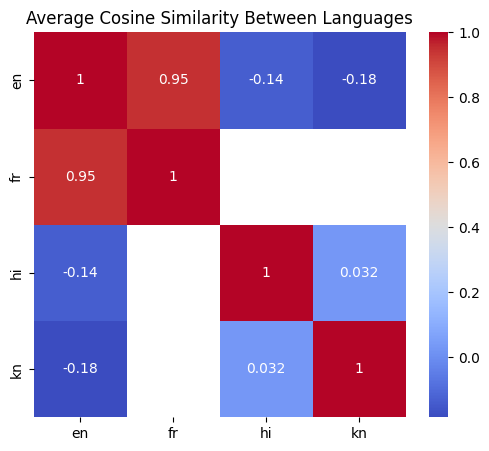

In [15]:
#Heat Map plot
languages = ["en", "fr", "hi", "kn"]
heatmap_data = np.zeros((4, 4))

# Build matrix from pairwise similarities
for i, lang1 in enumerate(languages):
    for j, lang2 in enumerate(languages):
        if lang1 == lang2:
            heatmap_data[i][j] = 1.0
        else:
            sims = df_sim[df_sim["Language Pair"] == f"{lang1.upper()}–{lang2.upper()}"]["Cosine Similarity"].tolist()
            if not sims:
                # Try reverse (e.g., FR–EN instead of EN–FR)
                sims = df_sim[df_sim["Language Pair"] == f"{lang2.upper()}–{lang1.upper()}"]["Cosine Similarity"].tolist()
            heatmap_data[i][j] = np.mean(sims)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, xticklabels=languages, yticklabels=languages, annot=True, cmap="coolwarm")
plt.title("Average Cosine Similarity Between Languages")
plt.show()

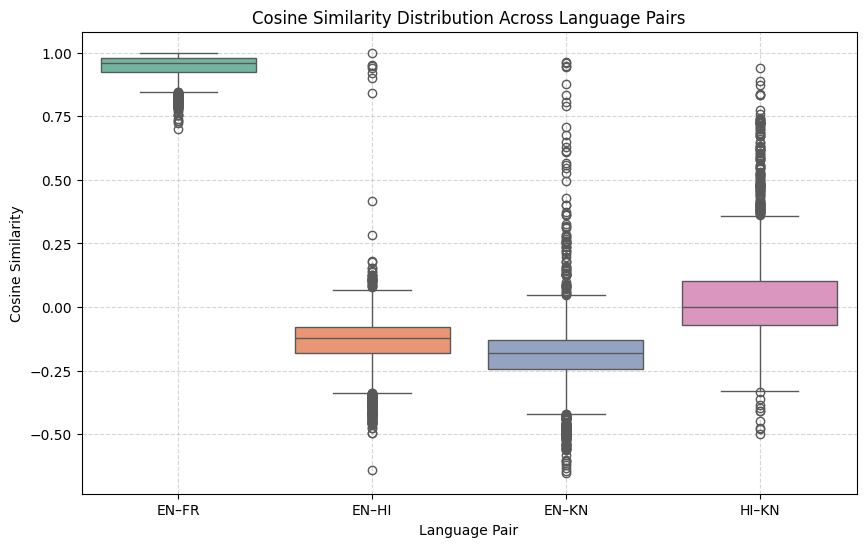

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Language Pair", y="Cosine Similarity", data=df_sim, hue="Language Pair",palette="Set2", legend=False)

plt.title("Cosine Similarity Distribution Across Language Pairs")
plt.ylabel("Cosine Similarity")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

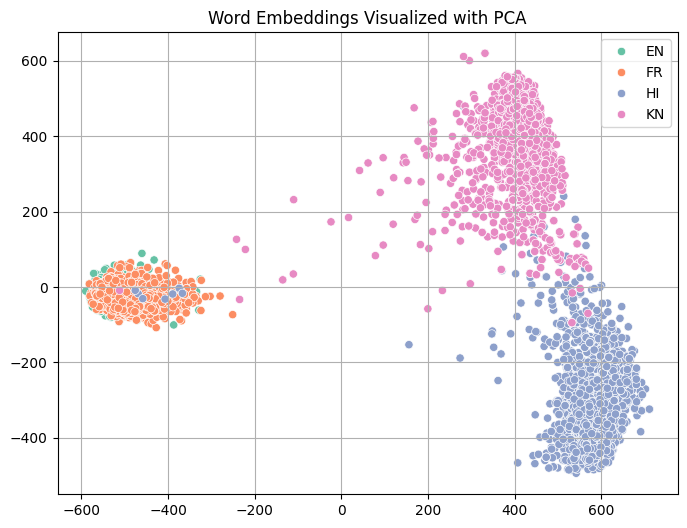

In [18]:
from sklearn.decomposition import PCA

# Combine embeddings from all languages
combined_embeddings = (
    embedding_dict["en"] +
    embedding_dict["fr"] +
    embedding_dict["hi"] +
    embedding_dict["kn"]
)

labels = (
    ["EN"] * len(embedding_dict["en"]) +
    ["FR"] * len(embedding_dict["fr"]) +
    ["HI"] * len(embedding_dict["hi"]) +
    ["KN"] * len(embedding_dict["kn"])
)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_embeddings)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="Set2")
plt.title("Word Embeddings Visualized with PCA")
plt.grid(True)
plt.show()

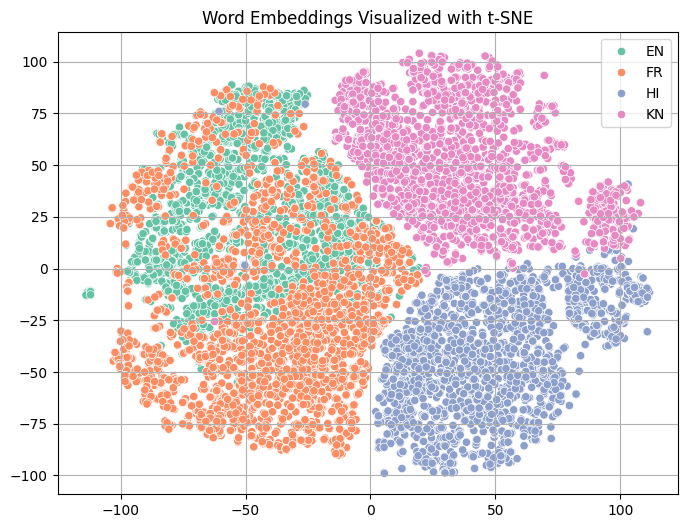

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
combined_embeddings_np = np.array(combined_embeddings)
tsne_result = tsne.fit_transform(combined_embeddings_np)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="Set2")
plt.title("Word Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()